# Experiments with `aihwkit`
## Exploring the sensitivity of analog inference, analog-aware retraining and in-analog training to the non-idealities of Analog Crossbars

In-memory computing uses crossbar arrays of non-volatile memories to perform Vector-Matrix Multiplications (VMMs) in-situ, i.e., in the memory where the matrix is stored, reducing the need of data movement and eliminating the von Neumann bottleneck. 
The VMM operation is one of the fundamental operations in the workload of neural networks, where vectors of activations are multiplied with arrays of weights. In analog crossbar implementations, the arrays of weights are programmed into memories and the vectors of activations are presented along the wordlines after being converted into analog values by arrays of DACs.
As such, the computation is performed in analog fashion and requires peripheral circuitry to interface with other digital elements. Once the multiplication is carried out in the analog domain in a fully parallel fashion, the sum-of-products produced on the bitlines are converted into digital values using ADCs for further propagation down the network. The figure below shows the general architecture of a crossbar array along with zoomed-in illustrations of the resistive memory cell and ADC circuitry.

| ![Crossbar architecture](https://github.com/AbinandN/aihwkit/blob/master/notebooks/img/xbar.png?raw=1) |
|:--:| 
| **(a) General Architecture of a Crossbar array with illustrations of (b) synaptic device and (c) ADC circuitry** (Reference: https://www.researchgate.net/publication/328091629_Memristor-based_Deep_Convolution_Neural_Network_A_Case_Study) |
 
The strength of the in-memory analog computing lies in the use of the non-volatile memory crossbar architecture to fully parallelize VMM (with a boost in operations per second) while decreasing the need of data movement (giving a significant reduction of the energy needed to run the array). 
However, analog computations introduce non-idealitites and trade-offs that could impact the accuracy of neural networks.

In a crossbar array, the weights are stored in synaptic devices called Resistive Processing Units (RPUs), which model analog memory cells. A two-dimensional array of RPUs makes up an Analog Tile in the toolkit.

This notebook studies the sensitivity of a crossbar implementation of a LeNet5 network trained on the MNIST dataset for handwritten digit recognition to a range of non-idealities introduced by the peripheral circuits and choice of synaptic device.

The first thing to do is to install `aihwkit` and its dependencies in your environment. The preferred way to install this package is by using the Python package index (please uncomment this line to install in your environment if not previously installed):

In [ ]:
# To install the cpu-only enabled kit, un-comment the line below
# %pip install aihwkit

# To install the GPU-enabled wheel go to https://aihwkit.readthedocs.io/en/latest/advanced_install.html#install-the-aihwkit-using-pip
# and copy the option on GPU options that best suits your enviroment and paste it below and run the cell. For example, Python 3.10 and CUDA 12.1:
# !wget https://aihwkit-gpu-demo.s3.us-east.cloud-object-storage.appdomain.cloud/aihwkit-0.9.2+cuda121-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
# %pip install aihwkit-0.9.2+cuda121-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl


If the library was installed correctly, you can use the following snippet for creating an analog layer and predicting the output:

In [1]:
from torch import Tensor
from aihwkit.nn import AnalogLinear

model = AnalogLinear(2, 2)
model(Tensor([[0.1, 0.2], [0.3, 0.4]]))

tensor([[ 0.4165, -0.6434],
        [ 0.4542, -0.6905]], grad_fn=<AddBackward0>)

In [2]:
# if jupyter
%matplotlib notebook

# if Google colab etc
# %matplotlib inline

Now that the package is installed and running, we can start with the experiments. We begin by importing the necessary libraries, defining the global settings and hyperparameters, and defining the helper functions required for our experiments.

In [2]:
# Imports and Helper Functions
import os
from datetime import datetime
from IPython.display import display, clear_output
import ipywidgets as widgets

import matplotlib.pyplot as plt
import numpy as np

# Imports from PyTorch.
import torch
from torch import nn
from torchvision import datasets, transforms

# Imports from aihwkit.
from aihwkit.nn import AnalogConv2d, AnalogLinear, AnalogSequential
from aihwkit.nn.conversion import convert_to_analog
from aihwkit.optim import AnalogSGD
from torch.optim import SGD
from aihwkit.simulator.configs import FloatingPointRPUConfig, SingleRPUConfig, UnitCellRPUConfig, InferenceRPUConfig, DigitalRankUpdateRPUConfig
from aihwkit.simulator.configs.devices import *
from aihwkit.simulator.configs.utils import PulseType
from aihwkit.simulator.rpu_base import cuda
from aihwkit.inference import BaseNoiseModel, PCMLikeNoiseModel, StateIndependentNoiseModel
from aihwkit.inference import GlobalDriftCompensation
from tqdm import tqdm

USE_CUDA = 0
if torch.cuda.is_available():
    USE_CUDA = 1
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
plt.style.use('ggplot')

# Path to store datasets
PATH_DATASET = os.path.join('data', 'DATASET')

# Training parameters
SEED = 1
N_EPOCHS = 40
BATCH_SIZE = 128
LEARNING_RATE = 0.01
N_CLASSES = 10


def load_images(bs):
    """Load images for train from torchvision datasets.
    
    Args:
        bs (int): batchsize
    """

    transform = transforms.Compose([transforms.ToTensor()])
    train_set = datasets.MNIST(PATH_DATASET, download=True, train=True, transform=transform)
    val_set = datasets.MNIST(PATH_DATASET, download=True, train=False, transform=transform)
    train_data = torch.utils.data.DataLoader(train_set, batch_size=bs, shuffle=True)
    validation_data = torch.utils.data.DataLoader(val_set, batch_size=bs, shuffle=False)

    return train_data, validation_data

def create_digital_optimizer(model, learning_rate):
    """Create the conventional "digital" optimizer.

    Args:
        model (nn.Module): model to be trained
        learning_rate (float): global parameter to define learning rate

    Returns:
        nn.Module: SGD optimizer
    """
    optimizer = SGD(model.parameters(), lr=learning_rate)
    
    return optimizer

def create_analog_optimizer(model, learning_rate):
    """Create the analog-aware optimizer.

    Args:
        model (nn.Module): model to be trained
        learning_rate (float): global parameter to define learning rate

    Returns:
        nn.Module: Analog optimizer
    """
    optimizer = AnalogSGD(model.parameters(), lr=learning_rate)
    optimizer.regroup_param_groups(model)

    return optimizer


def train_step(train_data, model, criterion, optimizer):
    """Train network.

    Args:
        train_data (DataLoader): Validation set to perform the evaluation
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
        optimizer (Optimizer): analog model optimizer

    Returns:
        nn.Module, nn.Module, float:  model, optimizer and loss for per epoch
    """
    total_loss = 0

    model.train()

    for images, labels in train_data:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        # Add training Tensor to the model (input).
        output = model(images)
        loss = criterion(output, labels)

        # Run training (backward propagation).
        loss.backward()

        # Optimize weights.
        optimizer.step()
        total_loss += loss.item() * images.size(0)
    epoch_loss = total_loss / len(train_data.dataset)

    return model, optimizer, epoch_loss


def test_evaluation(validation_data, model, criterion):
    """Test trained network.

    Args:
        validation_data (DataLoader): Validation set to perform the evaluation
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss

    Returns:
        nn.Module, float, float, float:  model, loss, error, and accuracy
    """
    total_loss = 0
    predicted_ok = 0
    total_images = 0

    model.eval()

    for images, labels in validation_data:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        pred = model(images)
        loss = criterion(pred, labels)
        total_loss += loss.item() * images.size(0)

        _, predicted = torch.max(pred.data, 1)
        total_images += labels.size(0)
        predicted_ok += (predicted == labels).sum().item()
        accuracy = predicted_ok/total_images*100
        error = (1-predicted_ok/total_images)*100

    epoch_loss = total_loss / len(validation_data.dataset)

    return model, epoch_loss, error, accuracy


def training_loop(model, criterion, optimizer, train_data, validation_data, epochs, fig, print_every=1):
    """Training loop.

    Args:
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
        optimizer (Optimizer): analog model optimizer
        train_data (DataLoader): Validation set to perform the evaluation
        validation_data (DataLoader): Validation set to perform the evaluation
        epochs (int): global parameter to define epochs number
        print_every (int): defines how many times to print training progress

    Returns:
        nn.Module, Optimizer, Tuple: model, optimizer,
            and a tuple of train losses, validation losses, and test
            error
    """
    train_losses = []
    valid_losses = []
    test_error = []

    # Train model
    for epoch in tqdm(range(0, epochs)):
        # Train_step
        model, optimizer, train_loss = train_step(train_data, model, criterion, optimizer)
        train_losses.append(train_loss)

        # Validate_step
        with torch.no_grad():
            model, valid_loss, error, accuracy = test_evaluation(
                validation_data, model, criterion)
            valid_losses.append(valid_loss)
            test_error.append(error)
            
        plt.clf()
        plt.gca().set_prop_cycle(None)
        plt.plot(range(1, epoch+2), train_losses, marker="o", label="Training")
        plt.plot(range(1, epoch+2), valid_losses, marker="o", label="Validation")
        plt.gca().set_prop_cycle(None)
        plt.plot(epoch+1, train_losses[-1], marker="o", markersize=10)
        plt.plot(epoch+1, valid_losses[-1], marker="o", markersize=10)
        plt.xlim([0.5, epochs+0.5])
        plt.ylim([0, max(train_losses)+0.25])
        plt.xticks(range(1, epochs+2))
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        fig.canvas.draw()

    return model, optimizer, (train_losses, valid_losses, test_error)

def create_analog_network(rpu_config):
    """Return a LeNet5 inspired analog model."""
    channel = [16, 32, 512, 128]
    model = AnalogSequential(
        AnalogConv2d(in_channels=1, out_channels=channel[0], kernel_size=5, stride=1,
                     rpu_config=rpu_config),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2),
        AnalogConv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=5, stride=1,
                     rpu_config=rpu_config),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2),
        nn.Tanh(),
        nn.Flatten(),
        AnalogLinear(in_features=channel[2], out_features=channel[3], rpu_config=rpu_config),
        nn.Tanh(),
        AnalogLinear(in_features=channel[3], out_features=N_CLASSES, rpu_config=rpu_config),
        nn.LogSoftmax(dim=1)
    )

    return model



## Baseline : Training Digital LeNet5

We begin by defining and training a conventional "digital" LeNet5 network on the MNIST task, which will act as the accuracy baseline for our experiments with analog inference, retraining and training.

In [3]:
epochss = widgets.IntSlider(value=5, min=1, max=80, step=1, description='Epochs:', disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='d')
batchsizes = widgets.IntSlider(value=100, min=10, max=100, step=10, description='Batchsize:', disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='d')
display(epochss)
display(batchsizes)

IntSlider(value=5, continuous_update=False, description='Epochs:', max=80, min=1)

IntSlider(value=100, continuous_update=False, description='Batchsize:', min=10, step=10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [10:01<00:00,  7.52s/it]


3

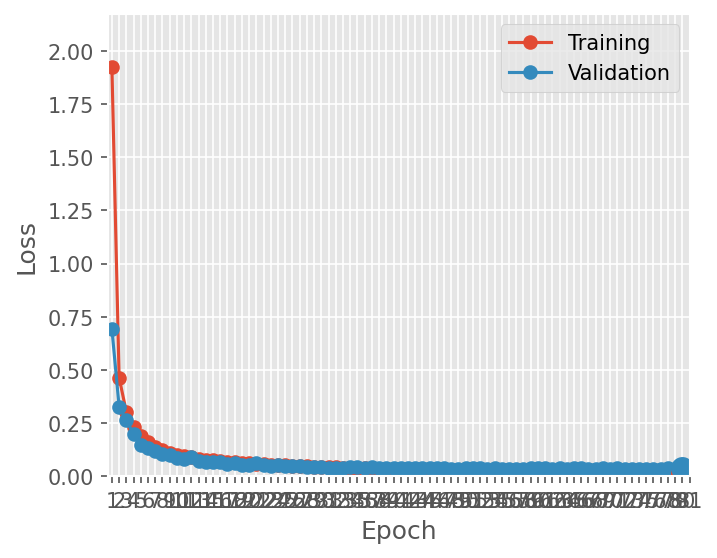

In [6]:

def create_digital_network():
    channel = [16, 32, 512, 128]
    model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=channel[0], kernel_size=5, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=5, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(in_features=channel[2], out_features=channel[3]),
        nn.ReLU(),
        nn.Linear(in_features=channel[3], out_features=N_CLASSES),
        nn.LogSoftmax(dim=1)
    )

    return model
epochs=80

train_data, validation_data = load_images(128)

# Prepare the model.
dmodel = create_digital_network()
dmodel.to(DEVICE)

optimizer = create_digital_optimizer(dmodel, LEARNING_RATE)

criterion = nn.CrossEntropyLoss()

fig = plt.figure(figsize=(5, 4), dpi=150)
dmodel, optimizer, _ = training_loop(dmodel, criterion, optimizer, train_data, validation_data, epochs, fig)
3#plt.show()


In [10]:
torch.save(dmodel,"trained-LeNet5_2.pth")

In [7]:
dmodel, _, _, digital_accuracy = test_evaluation(validation_data, dmodel, criterion)
print(f"Accuracy of the digital model: {digital_accuracy:.2f}%")

Accuracy of the digital model: 98.80%


In [12]:
from aihwkit.simulator.configs import (
    RPUDataType,
    InferenceRPUConfig,
    WeightRemapType,
    WeightModifierType,
    WeightClipType,
    NoiseManagementType,
    BoundManagementType,
)
from aihwkit.inference import ReRamCMONoiseModel
from aihwkit.inference import PCMLikeNoiseModel
from aihwkit.simulator.parameters.io import IOParametersIRDropT

input_prec = 32
wire=0.35
def gen_rpu_config():
    rpu_config = InferenceRPUConfig()
    rpu_config.forward.inp_res = 1 / (2**32 - 2)
    rpu_config.forward.out_res = 1 / (2**32 - 2)
    rpu_config.forward.inp_sto_round = False
    rpu_config.forward.inp_noise = 0
    rpu_config.forward.out_sto_round = False
    rpu_config.forward.out_noise = 0
    rpu_config.noise_model = ReRamCMONoiseModel(g_max=88.19, g_min=9.0,
                                                acceptance_range=2,
                                                drift_scale=1.0,
                                                prog_noise_scale=1.0,
                                                read_noise_scale=1.0)
    rpu_config.drift_compensation = None
    #my_rpu_config.remap.type = WeightRemapType.CHANNELWISE_SYMMETRIC
    #my_rpu_config.clip.type = WeightClipType.NONE
   # my_rpu_config.clip.sigma = 2.5

    # train input clipping
    rpu_config.forward = IOParametersIRDropT()
    rpu_config.forward.is_perfect = False
    rpu_config.forward.out_noise = 0.0
    rpu_config.forward.ir_drop_g_ratio = 1.0 / 0.35 / 88e-3
    rpu_config.forward.ir_drop = 0.0
    rpu_config.forward.ir_drop_rs = 0.35
    #rpu_config.forward.noise_management = NoiseManagementType.NONE
    #rpu_config.forward.bound_management = BoundManagementType.NONE
   # my_rpu_config.forward.out_bound = 10.0  # quite restrictive
   # my_rpu_config.pre_post.input_range.enable = True
   # my_rpu_config.pre_post.input_range.manage_output_clipping = True
   # my_rpu_config.pre_post.input_range.decay = 0.001
   # my_rpu_config.pre_post.input_range.input_min_percentage = 0.95
   # my_rpu_config.pre_post.input_range.output_min_percentage = 0.95
    #my_rpu_config.drift_compensation = None
    #my_rpu_config.forward = IOParameters()
    #my_rpu_config.forward.is_perfect = True
    #my_rpu_config.pre_post.input_range.manage_output_clipping = True
    #my_rpu_config.pre_post.input_range.decay = 0.001
    #my_rpu_config.pre_post.input_range.input_min_percentage = 0.95
    #my_rpu_config.pre_post.input_range.output_min_percentage = 0.95
    return rpu_config


In [13]:
rpu_config = gen_rpu_config()
amodel = convert_to_analog(dmodel, rpu_config)
amodel.eval()
amodel.program_analog_weights(noise_model=rpu_config.noise_model)
amodel, _, _, accuracy = test_evaluation(validation_data, amodel, criterion)
print(f"Accuracy of the analog model: {accuracy:.2f}%")
print(f"Accuracy degradation: {digital_accuracy-accuracy:.2f}%")

Accuracy of the analog model: 98.77%
Accuracy degradation: 0.18%


In [14]:
def test_step(model, criterion, testloader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    #print(f"Test loss {test_loss/total:.4f} test acc. {100.*correct/total:.2f}%")
    return 100.0 * correct / total

In [15]:
n_rep = 1
t_inferences = [0, 1, 5, 10, 3600, 3600 * 24, 3600 * 24 * 365 * 10]
#t_inferences = [1., 10., 60.]
drifted_test_accs = torch.zeros(size=(len(t_inferences),n_rep))
drifted_test_accs_baseline = torch.zeros(size=(len(t_inferences),n_rep))
#prog = test_step(converted_model, criterion, testloader)
#print(prog)
#amodel.eval()
#amodel.program_analog_weights(noise_model=rpu_config.noise_model)
for i,t in enumerate(t_inferences):
    amodel.drift_analog_weights(t)
    #print(amodel.get_weights()['0.analog_module'][0][:, 16])
    print("Drifted at t: ", t)
    accuracy = test_step(amodel, criterion, validation_data)
    print(f"Accuracy of the analog model: {accuracy:.2f}%")


Drifted at t:  0
Accuracy of the analog model: 98.75%
Drifted at t:  1
Accuracy of the analog model: 98.73%
Drifted at t:  5
Accuracy of the analog model: 98.84%
Drifted at t:  10
Accuracy of the analog model: 98.84%
Drifted at t:  3600
Accuracy of the analog model: 97.75%
Drifted at t:  86400
Accuracy of the analog model: 96.13%
Drifted at t:  315360000
Accuracy of the analog model: 88.95%


In [39]:
amodel.get_weights()['0.analog_module'][0][:, 16]

tensor([ 0.0431,  0.2019,  0.3987,  0.1836,  0.0779, -0.1314,  0.0337,  0.3023,
        -0.1607,  0.1303,  0.2944,  0.4863, -0.1640,  0.4584, -0.2009,  0.0304])

In [ ]:
print(converted_model.get_weights()['layer1.0.conv1.analog_module'][0][:,0])

## Experiment 1: Analog Inference

As a preliminary experiment, we perform "analog" inference of the previously trained digital LeNet with a floating point synaptic device model, while ignoring the non-idealities of peripheral circuits. We do this using the `FloatingPointRPUConfig`, which performs the computation of the analog tiles in full floating point precision while ignoring all non-idealities.

In [ ]:
rpu_config = FloatingPointRPUConfig(device=FloatingPointDevice())
amodel = convert_to_analog(dmodel, rpu_config)
print(amodel)

In [ ]:
amodel, _, _, accuracy = test_evaluation(validation_data, amodel, criterion)
print(f"Accuracy of the analog model: {accuracy:.2f}%")
print(f"Accuracy degradation: {digital_accuracy-accuracy:.2f}%")

## Experiment 2: Parameters of Analog Inference

In this experiment, we introduce a few of the non-idealities involved in analog inference. Experimenting with different settings for these factors shows the clear impact of analog inference on accuracy. We use the `InferenceRPUConfig`, which incorporates the non-idealities during forward pass and performs update and backward passes without any non-idealities.

In [ ]:
devices = widgets.Dropdown(
    options=['IdealDevice', 'ConstantStepDevice', 'LinearStepDevice', 'PowStepDevice', 'ExpStepDevicel'],
    value='IdealDevice',
    description='Device:',
    disabled=False,
)
configs = widgets.Dropdown(
    options=['SingleRPUConfig', 'InferenceRPUConfig'],
    value='SingleRPUConfig',
    description='Config:',
    disabled=False,
)
noise = widgets.Dropdown(
    options=['PCMLikeNoiseModel', 'StateIndependentNoiseModel'],
    value='PCMLikeNoiseModel',
    description='Noise model:',
    disabled=False,
)
DAC = widgets.SelectionSlider(options=[2**i for i in range(1, 11)], value=2**6, description='DAC steps:', disabled=False, continuous_update=False, orientation='horizontal', readout=True)
DACRnd = widgets.Checkbox(value=False, description='Stochastic Rounding', disabled=False, indent=False)
DACns = widgets.FloatSlider(value=0, min=0, max=1, step=.01, description='DAC noise:', disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f')
ADC = widgets.SelectionSlider(options=[2**i for i in range(1, 11)], value=2**6, description='ADC steps:', disabled=False, continuous_update=False, orientation='horizontal', readout=True)
ADCRnd = widgets.Checkbox(value=False, description='Stochastic Rounding', disabled=False, indent=False)
ADCns = widgets.FloatSlider(value=0, min=0, max=1, step=.01, description='ADC noise:', disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f')
time = widgets.FloatLogSlider(value=1000, base=10, min=0, max=10, step=1, description='Drift time:')
display(noise)
display(time)
display(widgets.HBox([DAC, DACRnd, DACns]))
display(widgets.HBox([ADC, ADCRnd, ADCns]))
deviceClasses = [IdealDevice, ConstantStepDevice, LinearStepDevice, PowStepDevice]
configClasses = [SingleRPUConfig, InferenceRPUConfig]
noiseClasses = [PCMLikeNoiseModel, StateIndependentNoiseModel]
device_map = {devices.options[i]: deviceClasses[i] for i in range(len(deviceClasses))}
config_map = {configs.options[i]: configClasses[i] for i in range(len(configClasses))}
noise_map = {noise.options[i]: noiseClasses[i] for i in range(len(noiseClasses))}

In [ ]:
rpu_config = InferenceRPUConfig()
rpu_config.forward.inp_res = DAC.value# if DAC.value > 0 else -1
rpu_config.forward.inp_sto_round = DACRnd.value
rpu_config.forward.inp_noise = DACns.value
rpu_config.forward.out_res = ADC.value# if DAC.value > 0 else -1
rpu_config.forward.out_sto_round = ADCRnd.value
rpu_config.forward.out_noise = ADCns.value
rpu_config.noise_model = noise_map[noise.value]()
rpu_config.drift_compensation = GlobalDriftCompensation()

amodel = convert_to_analog(dmodel, rpu_config)
amodel.eval()
amodel.program_analog_weights()
amodel.drift_analog_weights(time.value)
amodel, _, _, accuracy = test_evaluation(validation_data, amodel, criterion)
print(f"Accuracy of the analog model: {accuracy:.2f}%")
print(f"Accuracy degradation: {digital_accuracy-accuracy:.2f}%")

## Experiment 3: Parameter Sweep

In this experiment, we perform sweeps of the different non-idealitiy settings introduced in the previous experiment and visualize the impact of analog inference on accuracy.

In [ ]:
params = widgets.Dropdown(
    options=['DAC: steps', 'DAC: SR', 'DAC: noise', 'ADC: steps', 'ADC: SR', 'ADC: noise', 'Programming Noise Model', 'Drift time'],
    value='DAC: noise',
    description='Sweep:',
    disabled=False,
)
lock = widgets.Checkbox(value=False, description='Lock ADC and DAC', disabled=False, indent=False)

display(noise)
display(time)
display(widgets.HBox([DAC, DACRnd, DACns]))
display(widgets.HBox([ADC, ADCRnd, ADCns]))
display(widgets.HBox([params, lock]))


In [ ]:
wdgts = [DAC, DACRnd, DACns, ADC, ADCRnd, ADCns, noise, time]
wdgtsL = [ADC, ADCRnd, ADCns, DAC, DACRnd, DACns, noise, time]
sweeps = [[2**i for i in range(1, 11)], [False, True], [i/10 for i in range(0, 11)], [2**i for i in range(1, 11)], [False, True], [i/10 for i in range(0, 11)], ['PCMLikeNoiseModel', 'StateIndependentNoiseModel'], [10.0**i for i in range(11)]]
wdgt_map = {params.options[i]: wdgts[i] for i in range(len(wdgts))}
wdgtL_map = {params.options[i]: wdgtsL[i] for i in range(len(wdgts))}
sweep_map = {params.options[i]: sweeps[i] for i in range(len(sweeps))}
param = wdgt_map[params.value]
paramL = wdgtL_map[params.value]
sweep = sweep_map[params.value]

acc = np.zeros(len(sweep))
if lock.value and (params.value not in ['Programming Noise Model', 'Drift time']):
    display(widgets.HBox([param, paramL]))
else:
    display(param)
fig = plt.figure(figsize=(5, 4), dpi=150)

for i in range(len(sweep)):
    val = sweep[i]
    param.value = val
    if lock.value:
        paramL.value = val
    rpu_config = InferenceRPUConfig()
    rpu_config.forward.inp_res = DAC.value
    rpu_config.forward.inp_sto_round = DACRnd.value
    rpu_config.forward.inp_noise = DACns.value
    rpu_config.forward.out_res = ADC.value
    rpu_config.forward.out_sto_round = ADCRnd.value
    rpu_config.forward.out_noise = ADCns.value
    rpu_config.noise_model = noise_map[noise.value]()
    rpu_config.drift_compensation = GlobalDriftCompensation()


    amodel = convert_to_analog(dmodel, rpu_config)
    amodel.eval()
    amodel.program_analog_weights()
    amodel.drift_analog_weights(time.value)
    amodel, _, _, accuracy = test_evaluation(validation_data, amodel, criterion)
    acc[i] = accuracy
    plt.gca().set_prop_cycle(None)
    if params.value == 'Drift time':
        plt.bar([r"$10^{{{}}}$".format(int(np.log10(j))) for j in sweep], acc, width=.8)
        plt.hlines(digital_accuracy, r"$10^{{{}}}$".format(0), r"$10^{{{}}}$".format(10), linestyle="--")
    else:
        plt.bar([str(j) for j in sweep], acc, width=.8)
        plt.hlines(digital_accuracy, str(sweep[0]), str(sweep[-1]), linestyle="--")
    plt.ylim([min(acc)*.8, max(acc)*1.1])
    plt.ylabel("Accuracy in %")
    plt.xlabel(param.description[:-1])
    fig.canvas.draw()

plt.show()


## Experiment 4: Analog-aware Retraining

In this experiment, we perform analog-aware retraining of the digital LeNet model using the inference RPU configuration with the non-idealities of the peripheral circuitry in action. This experiment shows that with analog-aware retraining, accuracy degradation caused by analog non-idealities can be minimized. Please note that with the `InferenceRPUConfig`, the backward and update passes are performed without any non-idealities.

Refer: https://aihwkit.readthedocs.io/en/latest/hwa_training.html

In [ ]:
display(noise)
display(widgets.HBox([DAC, DACRnd, DACns]))
display(widgets.HBox([ADC, ADCRnd, ADCns]))

In [ ]:
rpu_config = InferenceRPUConfig()
rpu_config.forward.inp_res = DAC.value
rpu_config.forward.inp_sto_round = DACRnd.value
rpu_config.forward.inp_noise = DACns.value
rpu_config.forward.out_res = ADC.value
rpu_config.forward.out_sto_round = ADCRnd.value
rpu_config.forward.out_noise = ADCns.value
rpu_config.noise_model = noise_map[noise.value]()
rpu_config.drift_compensation = GlobalDriftCompensation()

amodel = convert_to_analog(dmodel, rpu_config)
amodel, _, _, accuracy = test_evaluation(validation_data, amodel, criterion)
print(f"Accuracy of the analog model: {accuracy:.2f}%")
print(f"Accuracy degradation: {digital_accuracy-accuracy:.2f}%")

display(epochss)
display(batchsizes)

In [ ]:
epochs = epochss.value
batchsize = batchsizes.value

train_data, validation_data = load_images(batchsize)
amodel = convert_to_analog(dmodel, rpu_config)
optimizer = create_analog_optimizer(amodel, LEARNING_RATE)

fig = plt.figure(figsize=(5, 4), dpi=150)
amodel, optimizer, _ = training_loop(amodel, criterion, optimizer, train_data, validation_data, epochs, fig)
plt.show()

display(time)

In [ ]:
amodel.program_analog_weights()
amodel.drift_analog_weights(time.value)
amodel, _, _, accuracy = test_evaluation(validation_data, amodel, criterion)
print(f"Accuracy of the analog model: {accuracy:.2f}%")
print(f"Accuracy degradation: {digital_accuracy-accuracy:.2f}%")

## Experiment 5: In-Analog Training

In this experiment, we explore the impact of non-idealities when the neural network is trained on a crossbar-based analog hardware platform. Here the non-idealities impact forward, backward and update passes of the training process. We note that the settings explored here are a subset of the capabilities of `aihwkit`. For example, the simulator comes with a number of preset RPU configurations as described here: https://aihwkit.readthedocs.io/en/latest/analog_training_presets.html

In [ ]:
mod = widgets.SelectionSlider(options=['From digital', 'From scratch'], value='From digital', description='Model init:', disabled=False, continuous_update=False, orientation='horizontal', readout=True)
display(epochss)
display(batchsizes)
display(mod)

print("RPU:")
display(devices)
display(configs)
print("Forward:")
display(widgets.HBox([DAC, DACRnd, DACns]))
display(widgets.HBox([ADC, ADCRnd, ADCns]))
print("Backward:")
bDAC = widgets.SelectionSlider(options=[2**i for i in range(1, 11)], value=2**6, description='DAC steps:', disabled=False, continuous_update=False, orientation='horizontal', readout=True)
bDACRnd = widgets.Checkbox(value=False, description='Stochastic Rounding', disabled=False, indent=False)
bDACns = widgets.FloatSlider(value=0, min=0, max=1, step=.01, description='DAC noise:', disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f')
bADC = widgets.SelectionSlider(options=[2**i for i in range(1, 11)], value=2**6, description='ADC steps:', disabled=False, continuous_update=False, orientation='horizontal', readout=True)
bADCRnd = widgets.Checkbox(value=False, description='Stochastic Rounding', disabled=False, indent=False)
bADCns = widgets.FloatSlider(value=0, min=0, max=1, step=.01, description='ADC noise:', disabled=False, continuous_update=False, orientation='horizontal', readout=True, readout_format='.2f')

display(widgets.HBox([bDAC, bDACRnd, bDACns]))
display(widgets.HBox([bADC, bADCRnd, bADCns]))

print('Update:')
desired_bl = widgets.IntSlider(value=31, min=1, max=31, step=1, description='Pulse train length:')
pulse = widgets.Dropdown(options=['Stochastic', 'Mean count', 'Deterministic'], value='Stochastic', description='Pulse type')
pulses = [PulseType.STOCHASTIC_COMPRESSED, PulseType.MEAN_COUNT, PulseType.DETERMINISTIC_IMPLICIT]
pulse_map = {pulse.options[i]:pulses[i] for i in range(len(pulses))}

display(desired_bl)
display(pulse)

In [ ]:
device = device_map[devices.value]
config = config_map[configs.value]
rpu_config = config(device=device())
rpu_config.drift_compensation = GlobalDriftCompensation()

rpu_config.forward.inp_res = DAC.value
rpu_config.forward.inp_sto_round = DACRnd.value
rpu_config.forward.inp_noise = DACns.value
rpu_config.forward.out_res = ADC.value
rpu_config.forward.out_sto_round = ADCRnd.value
rpu_config.forward.out_noise = ADCns.value

rpu_config.backward.inp_res = bDAC.value
rpu_config.backward.inp_sto_round = bDACRnd.value
rpu_config.backward.inp_noise = bDACns.value
rpu_config.backward.out_res = bADC.value
rpu_config.backward.out_sto_round = bADCRnd.value
rpu_config.backward.out_noise = bADCns.value

rpu_config.update.desired_bl = desired_bl.value
rpu_config.update.pulse_type = pulse_map[pulse.value]

epochs = epochss.value
batchsize = batchsizes.value

train_data, validation_data = load_images(batchsize)

if mod.value == 'From digital':
    amodel = convert_to_analog(dmodel, rpu_config)
else:
    amodel = create_analog_network(rpu_config).to(DEVICE)

optimizer = create_analog_optimizer(amodel, LEARNING_RATE)

if mod.value == 'From digital':
    amodel, _, _, accuracy = test_evaluation(validation_data, amodel, criterion)
    print(f"Accuracy of the analog model: {accuracy:.2f}%")
    print(f"Accuracy degradation: {digital_accuracy-accuracy:.2f}%")

fig = plt.figure(figsize=(5, 4), dpi=150)
amodel, optimizer, _ = training_loop(amodel, criterion, optimizer, train_data, validation_data, epochs, fig)
plt.show()


In [ ]:
amodel, _, _, accuracy = test_evaluation(validation_data, amodel, criterion)
print(f"Accuracy of the analog model: {accuracy:.2f}%")
if mod.value == 'From digital':
    print(f"Accuracy degradation: {digital_accuracy-accuracy:.2f}%")

**Acknowledgement**: This work was supported by the US Department of Energy Office of Science under the Microelectronics Co-Design Research program.